In [1]:
## For some reason we need this to install pyopencl on Colab
#import locale
#def getpreferredencoding(do_setlocale=True):
    #return "UTF-8"
#locale.getpreferredencoding = getpreferredencoding

In [2]:
#!pip install Mako

In [3]:
#!pip install pyopencl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.4/934.4 kB 13.8 MB/s eta 0:00:00a 0:00:01


In [4]:
## Only run this when using kaggle
#! sudo apt-get update

## Please install the following packages before running this notebook in google colab/kaggle
#! sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra -y
#! sudo apt install dvipng -y
#! sudo apt install cm-super -y

Get:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5002 B]
Get:2 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]       
Get:3 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:7 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:9 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [427 kB]
Get:10 https://packages.cloud.google.com/apt google-fast-socket/main amd64 Packages [448 B]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [993 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 

In [5]:
#import os

#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

/kaggle/input/rscamlth/RSCAM-Group-Project-/copy.ipynb
/kaggle/input/rscamlth/RSCAM-Group-Project-/GPU.psd
/kaggle/input/rscamlth/RSCAM-Group-Project-/Sequential Model.ipynb
/kaggle/input/rscamlth/RSCAM-Group-Project-/CheckDenseLayer.ipynb
/kaggle/input/rscamlth/RSCAM-Group-Project-/README.md
/kaggle/input/rscamlth/RSCAM-Group-Project-/Lottery Ticket.ipynb
/kaggle/input/rscamlth/RSCAM-Group-Project-/requirements.txt
/kaggle/input/rscamlth/RSCAM-Group-Project-/CheckFlatten.ipynb
/kaggle/input/rscamlth/RSCAM-Group-Project-/CheckUtils.ipynb
/kaggle/input/rscamlth/RSCAM-Group-Project-/CheckBatchNorm.ipynb
/kaggle/input/rscamlth/RSCAM-Group-Project-/CheckFunctions.ipynb
/kaggle/input/rscamlth/RSCAM-Group-Project-/GPU.png
/kaggle/input/rscamlth/RSCAM-Group-Project-/GPUCPU.png
/kaggle/input/rscamlth/RSCAM-Group-Project-/PyNetworkCPU/exceptions.py
/kaggle/input/rscamlth/RSCAM-Group-Project-/PyNetworkCPU/validation.py
/kaggle/input/rscamlth/RSCAM-Group-Project-/PyNetworkCPU/Sequential.py
/kaggl

In [6]:
#import sys
#sys.path.insert(1, "/kaggle/input/rscamlth/RSCAM-Group-Project-/")
import PyNetwork
from PyNetwork import ActivationFunctions,ErrorFunctions, MetricFunctions
import PyNetworkCPU
import pyopencl as cl
import pyopencl.array as cl_array
import numpy as np
import matplotlib.pyplot as plt

In [7]:
platform = cl.get_platforms()
devices = platform[0].get_devices()
context = cl.Context(devices)
queue = cl.CommandQueue(context)

In [8]:
#!pip install emnist

In [11]:
from emnist import extract_training_samples, extract_test_samples

In [12]:
# The letters dataset is handwritten letters, as opposed to handwritten digits
# Should make the problem a bit harder
x_train, y_train = extract_training_samples('letters')
x_test, y_test = extract_test_samples('letters')

# Make it start counting from 0
y_train = y_train - 1
y_test = y_test - 1

In [13]:
N = len(np.unique(y_train))
input_shape = (28, 28)
x_train = x_train.reshape(-1, *input_shape).astype(np.float32) / 255
x_test = x_test.reshape(-1, *input_shape).astype(np.float32) / 255

labels = np.eye(N)

y_train = labels[y_train.flatten()].astype(np.float32)
y_test = labels[y_test.flatten()].astype(np.float32)

In [46]:
def make_model(dense_nodes, activation_functions, masks, initialized_weights, 
               optimizer, input_shape=(28, 28)):
    assert len(dense_nodes) == len(activation_functions), \
            "Dense nodes and activation functions need to have the same length"
    
    # Build the network - assume we only use dense layers
    model = PyNetwork.Sequential()
    model.add(PyNetwork.layers.Input(input_shape))
    model.add(PyNetwork.layers.Flatten())
    model.add(PyNetwork.layers.Dense(dense_nodes[0], activation_function=activation_functions[0], l2=0.0, l1=0.0,
                                             trainable_mask=masks[0]))
    
    for nodes, function, mask in list(zip(dense_nodes, activation_functions, masks))[1:]:
        
        model.add(PyNetwork.layers.BatchNorm())
        
        dense_layer = PyNetwork.layers.Dense(nodes, activation_function=function, l2=0.00, l1=0.0,
                                             trainable_mask=mask)
        model.add(dense_layer)
        
    
    model.build(context, queue, loss_function='cross_entropy', optimizer=optimizer, metrics='accuracy')
    
    # Set the weights to the initialized_weights
    dense_layers = list(model.layers.values())[2:]
    for layer, W in zip(dense_layers, initialized_weights):
        if W is not None:
            layer.W_gpu = W.copy()
    
    # Set the weights not at the mask to zero
    for layer, mask in zip(dense_layers, masks):
        if mask is not None:
            layer.W_gpu *= mask
    
    return model

def make_model_wdl2(dense_nodes, activation_functions, masks, initialized_weights, 
               optimizer, input_shape=(28, 28)):
    assert len(dense_nodes) == len(activation_functions), \
            "Dense nodes and activation functions need to have the same length"
    
    # Build the network - assume we only use dense layers
    model = PyNetwork.Sequential()
    model.add(PyNetwork.layers.Input(input_shape))
    model.add(PyNetwork.layers.Flatten())
    model.add(PyNetwork.layers.Dense(dense_nodes[0], activation_function=activation_functions[0], l2=0.001, l1=0.0,
                                             trainable_mask=masks[0]))
    
    for nodes, function, mask in list(zip(dense_nodes, activation_functions, masks))[1:]:
        
        model.add(PyNetwork.layers.BatchNorm())
        
        dense_layer = PyNetwork.layers.Dense(nodes, activation_function=function, l2=0.00, l1=0.0,
                                             trainable_mask=mask)
        model.add(dense_layer)
        
    
    model.build(context, queue, loss_function='cross_entropy', optimizer=optimizer, metrics='accuracy')
    
    # Set the weights to the initialized_weights
    dense_layers = list(model.layers.values())[2:]
    for layer, W in zip(dense_layers, initialized_weights):
        if W is not None:
            layer.W_gpu = W.copy()
    
    # Set the weights not at the mask to zero
    for layer, mask in zip(dense_layers, masks):
        if mask is not None:
            layer.W_gpu *= mask
    
    return model

# test for LTH
def make_model2(dense_nodes, activation_functions, masks, initialized_weights, 
               optimizer, input_shape=(28, 28)):
    assert len(dense_nodes) == len(activation_functions), \
            "Dense nodes and activation functions need to have the same length"
    
    # Build the network - assume we only use dense layers
    model = PyNetwork.Sequential()
    model.add(PyNetwork.layers.Input(input_shape))
    model.add(PyNetwork.layers.Flatten())
    
    for nodes, function, mask in zip(dense_nodes, activation_functions, masks):
        
        dense_layer = PyNetwork.layers.Dense(nodes, activation_function=function, l2=0.00, l1=0.0,
                                             trainable_mask=mask)
        model.add(dense_layer)
    
    model.build(context, queue, loss_function='cross_entropy', optimizer=optimizer, metrics='accuracy')
    
    # Set the weights to the initialized_weights
    dense_layers = list(model.layers.values())[2:]
    for layer, W in zip(dense_layers, initialized_weights):
        if W is not None:
            layer.W_gpu = W.copy()
    
    # Set the weights not at the mask to zero
    for layer, mask in zip(dense_layers, masks):
        if mask is not None:
            layer.W_gpu *= mask
    
    return model

In [54]:
import random
random.seed(101)
# Full Network
dense_nodes = [300, 100, N]
activation_functions = ['relu', 'relu', 'softmax']

masks = [None] * 3
initialized_weights = [None] * 3

In [55]:
optimizer = PyNetwork.optimizers.Adam(learning_rate=0.0005)
model = make_model(dense_nodes, activation_functions, masks, initialized_weights, 
                   optimizer, input_shape=input_shape)

starting_weights = [layer.W_gpu.copy() 
                    for layer in model.layers.values() if isinstance(layer, PyNetwork.layers.Dense)]

In [56]:
# Transform x_train and y_train into C-contiguous
x_train = np.ascontiguousarray(x_train)
y_train = np.ascontiguousarray(y_train)
x_test = np.ascontiguousarray(x_test)
y_test = np.ascontiguousarray(y_test)

# Send data to device
x_train_gpu = cl_array.to_device(queue, x_train)
y_train_gpu = cl_array.to_device(queue, y_train)
x_test_gpu = cl_array.to_device(queue, x_test)
y_test_gpu = cl_array.to_device(queue, y_test)

In [57]:
model.train(x_train_gpu, y_train_gpu, epochs=3, batch_size=128, verbose=True)

trained_weights = [layer.W_gpu.copy()
                   for layer in model.layers.values() if isinstance(layer, PyNetwork.layers.Dense)]

Training on 124800 samples
Epoch 1/3
cross_entropy: 0.3708 - accuracy: 0.8906
Training on 124800 samples
Epoch 2/3
cross_entropy: 0.4029 - accuracy: 0.8672
Training on 124800 samples
Epoch 3/3
cross_entropy: 0.2814 - accuracy: 0.8984


In [58]:
print(model.evaluate(x_train_gpu, y_train_gpu))
print(model.evaluate(x_test_gpu, y_test_gpu))

(array(0.91255609), 'cross_entropy: 0.2745 - accuracy: 0.9126')
(array(0.88735577), 'cross_entropy: 0.3643 - accuracy: 0.8874')


In [59]:
### Traditional Pruning
original_weights = [model.layers[3].W_gpu.copy(), model.layers[5].W_gpu.copy()]
test_accuracy = []
train_accuracy = []

p_vals = np.linspace(0,1,21)

for p in p_vals:
    print(p)
    model.layers[3].W_gpu = original_weights[0].copy()
    model.layers[5].W_gpu = original_weights[1].copy()
    
    for para in [model.layers[3].W_gpu, model.layers[5].W_gpu]:
        threshold = np.quantile(abs(para.get()), p)
        mask = abs(para)>threshold
        para *= mask

    train_accuracy.append(model.evaluate(x_train_gpu, y_train_gpu)[0])
    test_accuracy.append(model.evaluate(x_test_gpu, y_test_gpu)[0])

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0


In [64]:
# Full Network (traditional pruning run weight decay)
dense_nodes = [300, 100, N]
activation_functions = ['relu', 'relu', 'softmax']

masks = [None] * 3
initialized_weights = [None] * 3

optimizer = PyNetwork.optimizers.Adam(learning_rate=0.0005)
model = make_model_wdl2(dense_nodes, activation_functions, masks, initialized_weights, 
                   optimizer, input_shape=input_shape)

starting_weights = [layer.W_gpu.copy() 
                    for layer in model.layers.values() if isinstance(layer, PyNetwork.layers.Dense)]

model.train(x_train_gpu, y_train_gpu, epochs=3, batch_size=128, verbose=True)

trained_weights = [layer.W_gpu.copy()
                   for layer in model.layers.values() if isinstance(layer, PyNetwork.layers.Dense)]

original_weights = [model.layers[3].W_gpu.copy(), model.layers[5].W_gpu.copy()]
test_accuracy2 = []
train_accuracy2 = []

p_vals = np.linspace(0, 1, 21)

for p in p_vals:
    print(p)
    model.layers[3].W_gpu = original_weights[0].copy()
    model.layers[5].W_gpu = original_weights[1].copy()
    
    for para in [model.layers[3].W_gpu, model.layers[5].W_gpu]:
        threshold = np.quantile(abs(para.get()), p)
        mask = abs(para)>threshold
        para *= mask

    train_accuracy2.append(model.evaluate(x_train_gpu, y_train_gpu)[0])
    test_accuracy2.append(model.evaluate(x_test_gpu, y_test_gpu)[0])

Training on 124800 samples
Epoch 1/3
cross_entropy: 0.4875 - accuracy: 0.8516
Training on 124800 samples
Epoch 2/3
cross_entropy: 0.5931 - accuracy: 0.8203
Training on 124800 samples
Epoch 3/3
cross_entropy: 0.5609 - accuracy: 0.8359
0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0


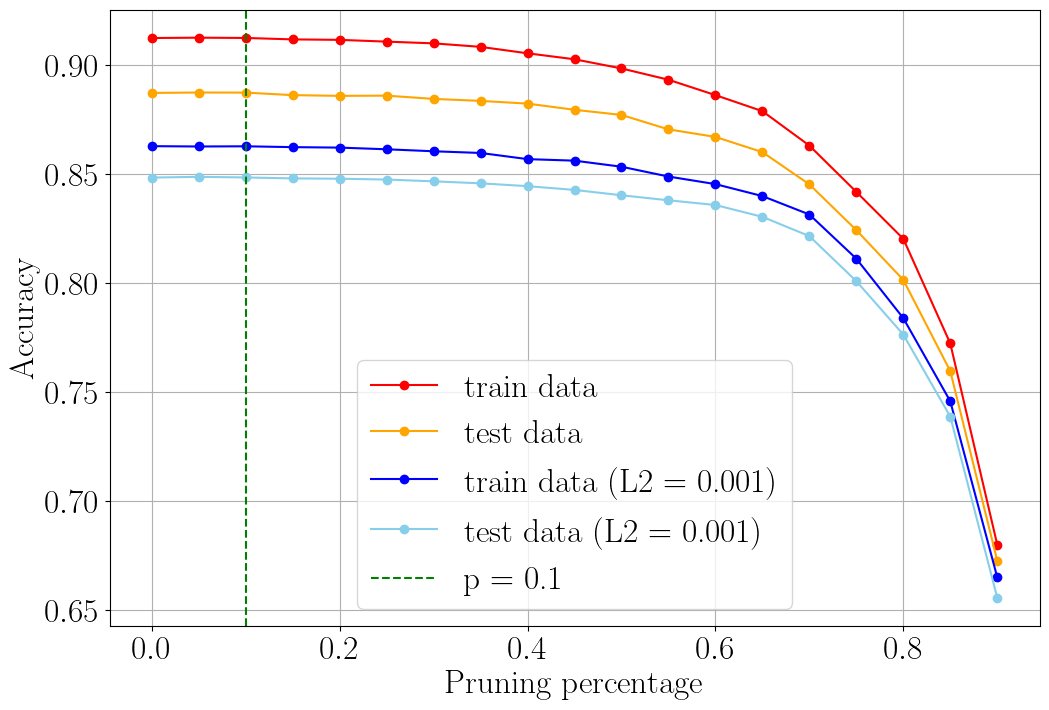

In [67]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Roman'],'size':24})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize=(12,8))
plt.plot(p_vals[:-2], train_accuracy[:-2], '-o', label='train data', color="red")
plt.plot(p_vals[:-2], test_accuracy[:-2], '-o', label='test data', color="orange")
plt.plot(p_vals[:-2], train_accuracy2[:-2], '-o', label='train data (L2 = 0.001)', color="blue")
plt.plot(p_vals[:-2], test_accuracy2[:-2], '-o', label='test data (L2 = 0.001)', color="skyblue")
plt.axvline(x = 0.1, color = 'g', linestyle = 'dashed', label = "p = 0.1")
plt.xlabel("Pruning percentage")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
#plt.title("Accuracy after applying different pruning percentages")
plt.savefig('PLTH1_24.pdf', bbox_inches='tight')
plt.show()

In [68]:
### LTH experiment
import random
random.seed(102)
dense_nodes = [300, 100, N]
activation_functions = ['relu', 'relu', 'softmax']

masks = [None] * 3
initialized_weights = [None] * 3

optimizer = PyNetwork.optimizers.Adam(learning_rate=0.0005)
model = make_model2(dense_nodes, activation_functions, masks, initialized_weights, 
                   optimizer, input_shape=input_shape)

starting_weights = [layer.W_gpu.copy() 
                    for layer in model.layers.values() if isinstance(layer, PyNetwork.layers.Dense)]

model.train(x_train_gpu, y_train_gpu, epochs=3, batch_size=128, verbose=True)

trained_weights = [layer.W_gpu.copy()
                   for layer in model.layers.values() if isinstance(layer, PyNetwork.layers.Dense)]

Training on 124800 samples
Epoch 1/3
cross_entropy: 0.5830 - accuracy: 0.8359
Training on 124800 samples
Epoch 2/3
cross_entropy: 0.2248 - accuracy: 0.9141
Training on 124800 samples
Epoch 3/3
cross_entropy: 0.2046 - accuracy: 0.9531


In [69]:
test_accuracylth = []
train_accuracylth = []

p_vals = np.linspace(0, 1, 21)

for p in p_vals:
    print(p)
    # LTH one-shot pruning
    # using original initialization
    masks = []
    for W in trained_weights:
        threshold = np.quantile(abs(W).get(), p)
        mask = abs(W) > threshold
    
        masks.append(mask)
    
    initialized_weights = starting_weights
    optimizer = PyNetwork.optimizers.Adam(learning_rate=0.0005)
    model = make_model2(dense_nodes, activation_functions, masks, initialized_weights, 
                   optimizer, input_shape=input_shape)
    
    model.train(x_train_gpu, y_train_gpu, epochs=3, batch_size=128, verbose=True)
    train_accuracylth.append(model.evaluate(x_train_gpu, y_train_gpu)[0])
    test_accuracylth.append(model.evaluate(x_test_gpu, y_test_gpu)[0])

0.0
Training on 124800 samples
Epoch 1/3
cross_entropy: 0.5582 - accuracy: 0.8438
Training on 124800 samples
Epoch 2/3
cross_entropy: 0.4012 - accuracy: 0.8594
Training on 124800 samples
Epoch 3/3
cross_entropy: 0.4311 - accuracy: 0.8672
0.05
Training on 124800 samples
Epoch 1/3
cross_entropy: 0.4689 - accuracy: 0.8672
Training on 124800 samples
Epoch 2/3
cross_entropy: 0.2867 - accuracy: 0.8984
Training on 124800 samples
Epoch 3/3
cross_entropy: 0.2180 - accuracy: 0.9219
0.1
Training on 124800 samples
Epoch 1/3
cross_entropy: 0.6137 - accuracy: 0.8672
Training on 124800 samples
Epoch 2/3
cross_entropy: 0.2717 - accuracy: 0.9219
Training on 124800 samples
Epoch 3/3
cross_entropy: 0.2560 - accuracy: 0.9219
0.15000000000000002
Training on 124800 samples
Epoch 1/3
cross_entropy: 0.3567 - accuracy: 0.8984
Training on 124800 samples
Epoch 2/3
cross_entropy: 0.2852 - accuracy: 0.9141
Training on 124800 samples
Epoch 3/3
cross_entropy: 0.3278 - accuracy: 0.9141
0.2
Training on 124800 samples


In [ ]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Roman'],'size':24})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize=(12,8))

plt.plot(p_vals, train_accuracylth, '-o', label='train data', color = 'red')
plt.plot(p_vals, test_accuracylth, '-o', label='test data', color = 'orange')
plt.xlabel("Pruning percentage")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
#plt.title("Accuracy after applying different pruning percentages")
#plt.savefig('PLTH2_24.pdf', bbox_inches='tight')
plt.show()